In [ ]:
# Same as SequenceClassification to predict the major. But considers electives as well, along with majors. 


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model,Sequential
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, Flatten
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
%matplotlib inline

seed = 7
np.random.seed(seed)


In [ ]:
df = pd.read_csv('ClassesElectivesFeb22.csv')

In [ ]:
df.head()

In [4]:
df.drop(['3', 'Unnamed: 0','0'],axis=1,inplace=True)
df.head()

,Courses,MajorPref
0,"[498, 914, 519, 784, 1101, 521, 1093, 1102, 52...",['Mechanical Engineering']
1,"[507, 508, 520, 516, 513, 519, 521, 511, 512, ...",['Mechanical Engineering']
2,"[921, 1246, 507, 922, 268, 498, 924, 1100, 518...",['Mechanical Engineering']
3,"[913, 507, 508, 519, 513, 517, 521, 520, 511]",['Mechanical Engineering']
4,"[914, 517, 519, 520, 508, 513, 516, 512, 401, ...",['Mechanical Engineering']


In [5]:
df.info()
# we have 186 plans right now

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188 entries, 0 to 187
Data columns (total 2 columns):
Courses      188 non-null object
MajorPref    188 non-null object
dtypes: object(2)
memory usage: 3.0+ KB


In [6]:
df[df.isnull().any(axis=1)].head()

,Courses,MajorPref


In [8]:
# number of courses(words) in each plan
df['token_length'] = [len(x.split(", ")) for x in df.Courses]
max(df.token_length)
# maximum number of courses of all the plans

33

In [9]:
# The plan with maximum number of courses
df.loc[df.token_length.idxmax(),'Courses']

'[916, 490, 266, 1093, 917, 505, 1246, 921, 1094, 507, 922, 1100, 349, 924, 1101, 344, 1329, 926, 1102, 913, 914, 517, 917, 505, 266, 921, 507, 1246, 922, 401, 268, 924, 1094]'

In [10]:
# Class distribution
# The classes are heavily unbalanced 
# They need to be balanced
df.MajorPref.value_counts()

['Mechanical Engineering']                       89
['General Major']                                29
['Computer Science']                             23
['Electrical Engineering']                       13
['Pharmacy']                                      8
['Graphic Design']                                5
['Chemical Engineering']                          5
['Nursing']                                       5
['Aeronautics Engineering']                       5
['Computer Engineering']                          3
['Computer Science and Software Engineering']     3
Name: MajorPref, dtype: int64

Text(0.5,1,'Major Distribution')

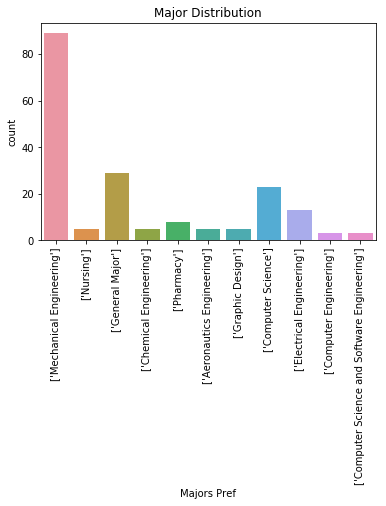

In [11]:
sns.countplot(df.MajorPref)
plt.xlabel('Majors Pref')
plt.xticks(rotation=90)
plt.title('Major Distribution')

In [12]:
majorsPref = df.groupby("MajorPref")

# Summary statistic of all countries
majorsPref.describe()


token_length             \
                                                     count       mean   
MajorPref                                                               
['Aeronautics Engineering']                            5.0  22.200000   
['Chemical Engineering']                               5.0  12.800000   
['Computer Engineering']                               3.0  29.333333   
['Computer Science and Software Engineering']          3.0  14.000000   
['Computer Science']                                  23.0   9.956522   
['Electrical Engineering']                            13.0  18.230769   
['General Major']                                     29.0   8.344828   
['Graphic Design']                                     5.0   5.000000   
['Mechanical Engineering']                            89.0  16.078652   
['Nursing']                                            5.0  15.000000   
['Pharmacy']                                           8.0  18.875000   

                                                                            \
                                                    std   min    25%   50%   
MajorPref                                                                    
['Aeronautics Engineering']                    0.447214  22.0  22.00  22.0   
['Chemical Engineering']                       0.447214  12.0  13.00  13.0   
['Computer Engineering']                       6.350853  22.0  27.50  33.0   
['Computer Science and Software Engineering']  1.732051  13.0  13.00  13.0   
['Computer Science']                           3.404252   5.0   9.00  10.0   
['Electrical Engineering']                     7.316122   4.0  14.00  19.0   
['General Major']                              6.043154   1.0   4.00   5.0   
['Graphic Design']                             0.000000   5.0   5.00   5.0   
['Mechanical Engineering']                     8.066802   1.0  10.00  15.0   
['Nursing']                                    0.000000  15.0  15.00  15.0   
['Pharmacy']                                   4.257347  12.0  18.75  21.0   

                                                           
                                                75%   max  
MajorPref                                                  
['Aeronautics Engineering']                    22.0  23.0  
['Chemical Engineering']                       13.0  13.0  
['Computer Engineering']                       33.0  33.0  
['Computer Science and Software Engineering']  14.5  16.0  
['Computer Science']                           10.0  18.0  
['Electrical Engineering']                     23.0  28.0  
['General Major']                              14.0  22.0  
['Graphic Design']                              5.0   5.0  
['Mechanical Engineering']                     23.0  28.0  
['Nursing']                                    15.0  15.0  
['Pharmacy']                                   21.0  22.0

In [13]:
from sklearn.feature_extraction.text import CountVectorizer


cvec = CountVectorizer()
cvec.fit(df.Courses)


CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [14]:
len(cvec.get_feature_names())

104

In [15]:

import seaborn as sns

me_doc_matrix = cvec.transform(df[df.MajorPref == "['Mechanical Engineering']"].Courses)
gm_doc_matrix = cvec.transform(df[df.MajorPref == "['General Major']"].Courses)
cs_doc_matrix = cvec.transform(df[df.MajorPref == "['Computer Science']"].Courses)
ee_doc_matrix = cvec.transform(df[df.MajorPref == "['Electrical Engineering']"].Courses)
ph_doc_matrix = cvec.transform(df[df.MajorPref == "['Pharmacy']"].Courses)
nu_doc_matrix = cvec.transform(df[df.MajorPref == "['Nursing']"].Courses)
gd_doc_matrix = cvec.transform(df[df.MajorPref == "['Graphic Design']"].Courses)
ae_doc_matrix = cvec.transform(df[df.MajorPref == "['Aeronautics Engineering']"].Courses)
ce_doc_matrix = cvec.transform(df[df.MajorPref == "['Chemical Engineering']"].Courses)
co_doc_matrix = cvec.transform(df[df.MajorPref == "['Computer Engineering']"].Courses)
cse_doc_matrix = cvec.transform(df[df.MajorPref == "['Computer Science and Software Engineering']"].Courses)


me_tf = np.sum(me_doc_matrix,axis=0)
gm_tf = np.sum(gm_doc_matrix,axis=0)
cs_tf = np.sum(cs_doc_matrix,axis=0)
ee_tf = np.sum(ee_doc_matrix,axis=0)
ph_tf = np.sum(ph_doc_matrix,axis=0)
nu_tf = np.sum(nu_doc_matrix,axis=0)
gd_tf = np.sum(gd_doc_matrix,axis=0)
ae_tf = np.sum(ae_doc_matrix,axis=0)
ce_tf = np.sum(ce_doc_matrix,axis=0)
co_tf = np.sum(co_doc_matrix,axis=0)
cse_tf = np.sum(cse_doc_matrix,axis=0)

me = np.squeeze(np.asarray(me_tf))
gm = np.squeeze(np.asarray(gm_tf))
cs = np.squeeze(np.asarray(cs_tf))
ee = np.squeeze(np.asarray(ee_tf))
ph = np.squeeze(np.asarray(ph_tf))
nu = np.squeeze(np.asarray(nu_tf))
gd = np.squeeze(np.asarray(gd_tf))
ae = np.squeeze(np.asarray(ae_tf))
ce = np.squeeze(np.asarray(ce_tf))
co = np.squeeze(np.asarray(co_tf))
cse = np.squeeze(np.asarray(cse_tf))


term_freq_df = pd.DataFrame([me,gm,cs,ee,ph,nu,gd,ae,ce,co,cse],columns=cvec.get_feature_names()).transpose()


term_freq_df.columns = ['me','gm','cs','ee','ph','nu','gd','ae','ce','co','cse']
term_freq_df['total']= term_freq_df['me']+term_freq_df['gm']+term_freq_df['cs']+term_freq_df['ee']+term_freq_df['ph']+term_freq_df['nu']+term_freq_df['gd']+term_freq_df['ae']+term_freq_df['ce']+term_freq_df['co']+term_freq_df['cse']
term_freq_df.sort_values(by='total', ascending=False).iloc[:10]
print(term_freq_df)



      me  gm  cs  ee  ph  nu  gd  ae  ce  co  cse  total
1068   1   0   0   0   0   0   0   0   0   0    0      1
1071   0   0   0   0   8   0   0   0   0   0    0      8
1074   0   1   0   0   0   0   0   0   0   0    0      1
1075   0   0   1   0   0   0   0   0   0   0    0      1
1076   0   0   0   0   0   0   5   0   0   0    3      8
109    0   0   0   0   0   0   5   0   0   0    3      8
1093  39   6   0   7   0   0   0   0   0   3    0     55
1094  24   2   4   6   0   0   0   5   5   5    3     54
1095   0   1   0   0   0   0   0   0   0   0    0      1
1097   0   6   0   3   0   0   0   0   0   0    0      9
1100  58   5  19   9   0   0   0   5   5   3    0    104
1101  61  11   3  11   0   0   0   5   5   3    0     99
1102  61  11   3  12   0   0   0   5   5   3    0    100
1133   0  11   0   0   6   5   0   0   0   0    0     22
1134   0   5   0   0   0   5   0   0   0   0    0     10
1155   0   0   0   0   0   5   0   0   0   0    0      5
1170   0   6   0   0   0   0   

In [51]:
def barplot(x_data, y_data, x_label="", y_label="", title=""):
    fig, ax = plt.subplots()
    # Draw bars, position them in the center of the tick mark on the x-axis
    ax.bar(x_data, y_data, color = '#539caf', align = 'center')
    # Draw error bars to show standard deviation, set ls to 'none'
    # to remove line between points
#     ax.errorbar(x_data, y_data, yerr = error_data, color = '#297083', ls = 'none', lw = 2, capthick = 2)
    fig = plt.figure(figsize=(35,15))
    ax.set_ylabel(y_label)
    ax.set_xlabel(x_label)
    ax.set_xticklabels(x_data,rotation=90)
#     fig = plt.xticks(rotation='vertical')
#     plt.xticks(rotation=45)
    ax.set_title(title)

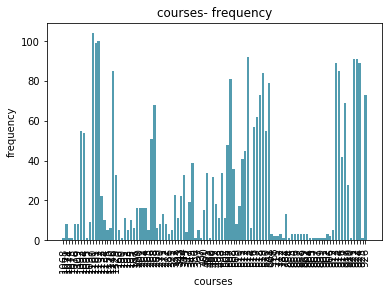

<Figure size 2520x1080 with 0 Axes>

In [52]:
barplot(cvec.get_feature_names(),term_freq_df['total'],"courses ","frequency","courses- frequency")

In [ ]:
course = df[df.MajorPref == "['Mechanical Engineering']"]
course_string = []
for t in course.Courses:
    t=t[1:len(t)-1]
    course_string = course_string + t.split(", ")

course_string = pd.Series(course_string).str.cat(sep=' ')
# print(course_string)
words = course_string.split(" ")
comment_words = ' '

for i in range(len(words)):
    words[i] = words[i].lower() 
for w in words: 
    comment_words = comment_words + w+' ' 

# print(comment_words)

In [ ]:
from wordcloud import WordCloud
import re


wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(comment_words)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Text(0.5,1,'Top Courses')

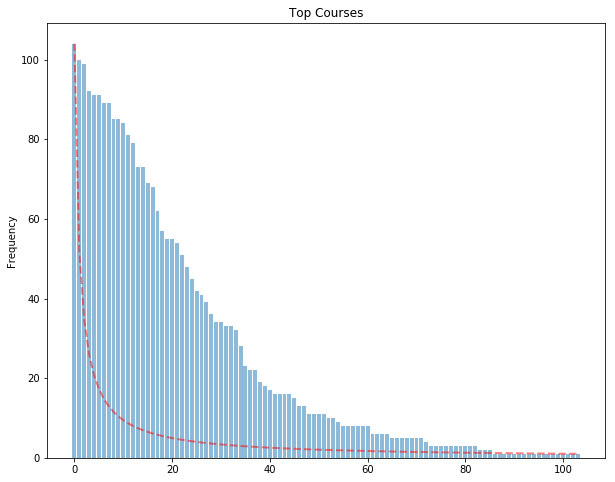

In [17]:
# zipf

y_pos = np.arange(104)
plt.figure(figsize=(10,8))
s = 1
expected_zipf = [term_freq_df.sort_values(by='total', ascending=False)['total'][0]/(i+1)**s for i in y_pos]
plt.bar(y_pos, term_freq_df.sort_values(by='total', ascending=False)['total'][:500], align='center', alpha=0.5)
plt.plot(y_pos, expected_zipf, color='r', linestyle='--',linewidth=2,alpha=0.5)
plt.ylabel('Frequency')
plt.title('Top Courses')

stop_words : are the words which do not add any meaning to the document. Since in this document, we dont have any such words, we selected the stop_words = none. 


TF IDF is a crude but effective way of distilling documents down to a reasonable and manageable abstraction. However, trade off is this process removes a lot of the semantic information that was in the document, such as Entities (“West Virginia”) and word ordering “toy dog” vs “dog toy” and distances between words.


For unique word in each document, count how many times it shows up in that document. That's “Term Frequency” (TF)

Then, take that unique word and count how many times it shows up in all documents. That's “Document Frequency” (DF)

You can massage DF but next, you divide TF by modified DF (Inverse DF) for each word.

The vectorization part is building a big Vector consisting of each unique word, which is potentially large (tens of thousands of unique words).

Now, if you have a query document, you can build its TF-IDF Vector and find the documents with TF-IDF from the corpus that's “nearest” to the query document. Or use the Vectors to cluster the documents.

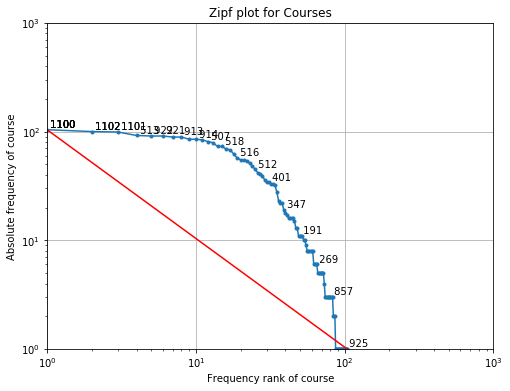

In [18]:
from pylab import *
counts = term_freq_df.total
tokens = term_freq_df.index
ranks = arange(1, len(counts)+1)
indices = argsort(-counts)
frequencies = counts[indices]
plt.figure(figsize=(8,6))
plt.ylim(1,10**3)
plt.xlim(1,10**3)
loglog(ranks, frequencies, marker=".")
plt.plot([1,frequencies[0]],[frequencies[0],1],color='r')
title("Zipf plot for Courses")
xlabel("Frequency rank of course")
ylabel("Absolute frequency of course")
grid(True)
for n in list(logspace(-0.5, log10(len(counts)-2), 25).astype(int)):
    dummy = text(ranks[n], frequencies[n], " " + tokens[indices[n]], 
                 verticalalignment="bottom",
                 horizontalalignment="left")

# Confusion Matrix and Splitting

In [19]:
x = df.Courses
y = df.MajorPref
from sklearn.cross_validation import train_test_split
SEED = 2000

/Users/sgaruda/anaconda3/lib/python3.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [20]:
x_train, x_validation_and_test, y_train, y_validation_and_test = train_test_split(x, y, test_size=.02, random_state=SEED)

In [21]:
x_validation, x_test, y_validation, y_test = train_test_split(x_validation_and_test, y_validation_and_test, test_size=.5, random_state=SEED)

# Logistic Regression without Sampling

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer

# tf : term frequency
# idf : Inverse  document frequency

tvec = TfidfVectorizer(stop_words=None, max_features=100000, ngram_range=(1, 3))
lr = LogisticRegression()


from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score

def lr_cv(splits, X, Y, pipeline, average_method):
    
    kfold = StratifiedKFold(n_splits=splits, shuffle=True, random_state=777)
    accuracy = []
    precision = []
    recall = []
    f1 = []
    for train, test in kfold.split(X, Y):
        lr_fit = pipeline.fit(X[train], Y[train])
        prediction = lr_fit.predict(X[test])
        scores = lr_fit.score(X[test],Y[test])
        
        accuracy.append(scores * 100)
        precision.append(precision_score(Y[test], prediction, average=average_method)*100)
        
        print('precision:\n',precision_score(Y[test], prediction, average=None))
        recall.append(recall_score(Y[test], prediction, average=average_method)*100)
        print('recall:\n   ',recall_score(Y[test], prediction, average=None))
        f1.append(f1_score(Y[test], prediction, average=average_method)*100)
        print('f1 score:\n ',f1_score(Y[test], prediction, average=None))
        print('-'*50)

    print("accuracy: %.2f%% (+/- %.2f%%)" % (np.mean(accuracy), np.std(accuracy)))
    print("precision: %.2f%% (+/- %.2f%%)" % (np.mean(precision), np.std(precision)))
    print("recall: %.2f%% (+/- %.2f%%)" % (np.mean(recall), np.std(recall)))
    print("f1 score: %.2f%% (+/- %.2f%%)" % (np.mean(f1), np.std(f1)))


In [23]:
from sklearn.pipeline import Pipeline
original_pipeline = Pipeline([
    ('vectorizer', tvec),
    ('classifier', lr)
])
lr_cv(5, df.Courses, df.MajorPref, original_pipeline, 'macro')

/Users/sgaruda/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
/Users/sgaruda/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/sgaruda/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/sgaruda/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'pred

precision:
 [0.         1.         0.         0.         0.83333333 0.
 1.         1.         0.69230769 1.         1.        ]
recall:
    [0.  1.  0.  0.  1.  0.  0.5 1.  1.  1.  1. ]
f1 score:
  [0.         1.         0.         0.         0.90909091 0.
 0.66666667 1.         0.81818182 1.         1.        ]
--------------------------------------------------
precision:
 [1.         1.         0.83333333 0.         0.66666667 1.
 0.76190476 1.         1.        ]
recall:
    [1.         1.         1.         0.         0.66666667 1.
 0.88888889 1.         0.5       ]
f1 score:
  [1.         1.         0.90909091 0.         0.66666667 1.
 0.82051282 1.         0.66666667]
--------------------------------------------------
precision:
 [1.         1.         0.         0.         1.         0.
 0.83333333 1.         0.70833333 1.         1.        ]
recall:
    [1.         1.         0.         0.         0.8        0.
 0.83333333 1.         0.94444444 1.         1.        ]
f1 score:


/Users/sgaruda/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/sgaruda/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/sgaruda/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/sgaruda/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Logistic Regression with OverSampling with TEsting and Training

In [24]:
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler
ROS_pipeline = make_pipeline(tvec, RandomOverSampler(random_state=777),lr)



In [25]:
# Create input and output vectors.
# Process the labels.

X = df.Courses
Y = df.MajorPref
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = Y.reshape(-1,1)


In [26]:
# Split into training and test data.

X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.10)




In [27]:
tv = TfidfVectorizer(stop_words=None, max_features=40)
testing_tfidf = tv.fit_transform(X_test)
ros = RandomOverSampler(random_state=777)
X_ROS, y_ROS = ros.fit_sample(testing_tfidf, Y_test)
pd.DataFrame(testing_tfidf.todense(), columns=tv.get_feature_names())


/Users/sgaruda/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/sgaruda/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,1093,1094,1100,1101,1102,1133,1170,1246,1329,264,...,906,912,913,914,916,917,921,922,924,926
0,0.232317,0.270451,0.000000,0.191893,0.181091,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.181091,0.171230,0.000000,0.232317,0.181091,0.181091,0.191893,0.203834
1,0.000000,0.266223,0.178260,0.188893,0.178260,0.000000,0.000000,0.213788,0.000000,0.000000,...,0.000000,0.000000,0.178260,0.168553,0.323212,0.228685,0.178260,0.178260,0.188893,0.200647
2,0.199813,0.232611,0.155754,0.165045,0.155754,0.000000,0.000000,0.373592,0.000000,0.000000,...,0.321929,0.000000,0.155754,0.147272,0.282405,0.199813,0.155754,0.155754,0.165045,0.175315
3,0.000000,0.000000,0.224274,0.000000,0.000000,0.000000,0.000000,0.000000,0.334942,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.287715,0.224274,0.224274,0.000000,0.000000
4,0.227849,0.000000,0.177609,0.000000,0.177609,0.000000,0.000000,0.213007,0.265250,0.000000,...,0.000000,0.000000,0.177609,0.167937,0.000000,0.000000,0.000000,0.177609,0.188203,0.199914
5,0.000000,0.000000,0.279322,0.295983,0.279322,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.506453,0.279322,0.264111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.276024,0.184823,0.195847,0.184823,0.000000,0.000000,0.221659,0.000000,0.000000,...,0.000000,0.000000,0.184823,0.174758,0.000000,0.237104,0.184823,0.184823,0.195847,0.208035
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.431417,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.288872,0.306104,0.325152
8,0.283275,0.000000,0.220813,0.233984,0.220813,0.000000,0.000000,0.264821,0.000000,0.000000,...,0.000000,0.000000,0.220813,0.000000,0.000000,0.000000,0.000000,0.220813,0.233984,0.248544
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.320678,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [28]:
pd.DataFrame(X_ROS.todense(), columns=tv.get_feature_names())

,1093,1094,1100,1101,1102,1133,1170,1246,1329,264,...,906,912,913,914,916,917,921,922,924,926
0,0.232317,0.270451,0.000000,0.191893,0.181091,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.181091,0.171230,0.000000,0.232317,0.181091,0.181091,0.191893,0.203834
1,0.000000,0.266223,0.178260,0.188893,0.178260,0.000000,0.000000,0.213788,0.000000,0.000000,...,0.000000,0.000000,0.178260,0.168553,0.323212,0.228685,0.178260,0.178260,0.188893,0.200647
2,0.199813,0.232611,0.155754,0.165045,0.155754,0.000000,0.000000,0.373592,0.000000,0.000000,...,0.321929,0.000000,0.155754,0.147272,0.282405,0.199813,0.155754,0.155754,0.165045,0.175315
3,0.000000,0.000000,0.224274,0.000000,0.000000,0.000000,0.000000,0.000000,0.334942,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.287715,0.224274,0.224274,0.000000,0.000000
4,0.227849,0.000000,0.177609,0.000000,0.177609,0.000000,0.000000,0.213007,0.265250,0.000000,...,0.000000,0.000000,0.177609,0.167937,0.000000,0.000000,0.000000,0.177609,0.188203,0.199914
5,0.000000,0.000000,0.279322,0.295983,0.279322,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.506453,0.279322,0.264111,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.276024,0.184823,0.195847,0.184823,0.000000,0.000000,0.221659,0.000000,0.000000,...,0.000000,0.000000,0.184823,0.174758,0.000000,0.237104,0.184823,0.184823,0.195847,0.208035
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.431417,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.288872,0.306104,0.325152
8,0.283275,0.000000,0.220813,0.233984,0.220813,0.000000,0.000000,0.264821,0.000000,0.000000,...,0.000000,0.000000,0.220813,0.000000,0.000000,0.000000,0.000000,0.220813,0.233984,0.248544
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.320678,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [29]:
y_ROS

array([6, 0, 8, 4, 5, 8, 8, 6, 6, 8, 8, 6, 4, 8, 8, 6, 6, 6, 8, 6, 0, 0,
       0, 0, 0, 0, 0, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5])

In [30]:
lr_cv(5, df.Courses, df.MajorPref, ROS_pipeline, 'macro')

/Users/sgaruda/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:605: Warning: The least populated class in y has only 3 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


precision:
 [1.         1.         1.         1.         1.         1.
 1.         1.         0.85714286 1.         1.        ]
recall:
    [1.  1.  1.  1.  1.  1.  0.5 1.  1.  1.  1. ]
f1 score:
  [1.         1.         1.         1.         1.         1.
 0.66666667 1.         0.92307692 1.         1.        ]
--------------------------------------------------
precision:
 [0.5        1.         0.83333333 1.         0.66666667 1.
 0.94117647 1.         1.        ]
recall:
    [1.         1.         1.         0.66666667 0.66666667 1.
 0.88888889 1.         1.        ]
f1 score:
  [0.66666667 1.         0.90909091 0.8        0.66666667 1.
 0.91428571 1.         1.        ]
--------------------------------------------------
precision:
 [1.         1.         1.         1.         1.         1.
 0.85714286 1.         1.         1.         1.        ]
recall:
    [1.         1.         1.         1.         1.         1.
 1.         1.         0.94444444 1.         1.        ]
f1 score:


/Users/sgaruda/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/sgaruda/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/sgaruda/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/sgaruda/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/sgaruda/anaconda3/lib/python3.7/site-

# ANN  with Keras

# RNN

In [46]:
# Process the data
# Tokenize the data and convert the text to sequences.
# Add padding to ensure that all the sequences have the same shape.
# There are many ways of taking the max_len and here an arbitrary length of 150 is chosen.

max_words = 35
max_len = 35
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)


In [47]:
# RNN
# Define the RNN structure.

def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,40,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [48]:
model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 35)                0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 35, 40)            1400      
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                26880     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation_3 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 257       
__________

In [49]:
model.fit(sequences_matrix,Y_train,batch_size=128,epochs=10,
          validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

Train on 133 samples, validate on 34 samples
Epoch 1/10
133/133 [==============================] - 1s 9ms/step - loss: 0.6782 - acc: 0.0301 - val_loss: -0.0228 - val_acc: 0.0294
Epoch 2/10
133/133 [==============================] - 0s 813us/step - loss: -0.1019 - acc: 0.0301 - val_loss: -2.6163 - val_acc: 0.0294
Epoch 3/10
133/133 [==============================] - 0s 789us/step - loss: -3.0532 - acc: 0.0301 - val_loss: -24.2160 - val_acc: 0.0294
Epoch 4/10
133/133 [==============================] - 0s 725us/step - loss: -26.7598 - acc: 0.0301 - val_loss: -49.6734 - val_acc: 0.0294
Epoch 5/10
133/133 [==============================] - 0s 710us/step - loss: -54.4679 - acc: 0.0301 - val_loss: -70.2159 - val_acc: 0.0294
Epoch 6/10
133/133 [==============================] - 0s 766us/step - loss: -75.3682 - acc: 0.0301 - val_loss: -82.0206 - val_acc: 0.0294
Epoch 7/10
133/133 [==============================] - 0s 844us/step - loss: -86.8660 - acc: 0.0301 - val_loss: -82.0564 - val_acc: 0.02

In [50]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

In [51]:
accr = model.evaluate(test_sequences_matrix,Y_test)

19/19 [==============================] - 0s 409us/step


In [52]:
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Test set
  Loss: -83.907
  Accuracy: 0.000
